# Tutorial on implementing voltage dependent synaptic plasticity in Nengo

## Author : Nikhil Garg

### Last updated : 3rd July 2021

In [1]:
#Import statements
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import random
import os

from nengo.utils.ensemble import response_curves, tuning_curves
from nengo_extras.plot_spikes import (cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from nengo.utils.matplotlib import rasterplot

from nengo.dists import Choice, Distribution, get_samples, Uniform
from mpl_toolkits.mplot3d import Axes3D
from nengo.neurons import LIFRate
from nengo.params import Parameter, NumberParam, FrozenObject
from nengo.utils.numpy import clip, is_array_like



In [23]:
class MyLIF_in(LIFRate):
    """Spiking version of the leaky integrate-and-fire (LIF) neuron model.

    Parameters
    ----------
    tau_rc : float
        Membrane RC time constant, in seconds. Affects how quickly the membrane
        voltage decays to zero in the absence of input (larger = slower decay).
    tau_ref : float
        Absolute refractory period, in seconds. This is how long the
        membrane voltage is held at zero after a spike.
    min_voltage : float
        Minimum value for the membrane voltage. If ``-np.inf``, the voltage
        is never clipped.
    amplitude : float
        Scaling factor on the neuron output. Corresponds to the relative
        amplitude of the output spikes of the neuron.
    initial_state : {str: Distribution or array_like}
        Mapping from state variables names to their desired initial value.
        These values will override the defaults set in the class's state attribute.
    """

    state = {
        "voltage": Uniform(low=0, high=1),
        "refractory_time": Choice([0]),
    }
    spiking = True

    min_voltage = NumberParam("min_voltage", high=0)

    def __init__(
        self, tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=1, initial_state=None
    ):
        super().__init__(
            tau_rc=tau_rc,
            tau_ref=tau_ref,
            amplitude=amplitude,
            initial_state=initial_state,
        )
        self.min_voltage = min_voltage

    def step(self, dt, J, output, voltage, refractory_time):
        # look these up once to avoid repeated parameter accesses
        tau_rc = self.tau_rc
        min_voltage = self.min_voltage

        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = clip((dt - refractory_time), 0, dt)

        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        voltage -= (J - voltage) * np.expm1(-delta_t / tau_rc)

        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > 1
        output[:] = spiked_mask * (self.amplitude / dt)

        # set v(0) = 1 and solve for t to compute the spike time
        t_spike = dt + tau_rc * np.log1p(
            -(voltage[spiked_mask] - 1) / (J[spiked_mask] - 1)
        )
        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < min_voltage] = min_voltage
        voltage[spiked_mask] = -1 #reset voltage
        refractory_time[spiked_mask] = self.tau_ref + t_spike

In [49]:
import nengo
from nengo.builder import Builder
from nengo.builder.learning_rules import get_pre_ens, get_post_ens
from nengo.builder.operator import Operator
from nengo.builder.signal import Signal
from nengo.params import BoolParam, NumberParam, StringParam
import numpy as np


# ================
# Frontend objects
# ================
#
# These objects are the ones that you include in your model description.
# They are applied to specific connections between groups of neurons.

class STDP(nengo.learning_rules.LearningRuleType):
    """Spike-timing dependent plasticity rule."""

    # Used by other Nengo objects
    modifies = 'weights'
    probeable = ('pre_trace', 'post_trace', 'pre_scale', 'post_scale')

    # Parameters
    pre_tau = NumberParam('pre_tau', low=0, low_open=True)
    pre_amp = NumberParam('pre_amp', low=0, low_open=True)
    post_tau = NumberParam('post_tau', low=0, low_open=True)
    post_amp = NumberParam('post_amp', low=0, low_open=True)
    bounds = StringParam('bounds')
    max_weight = NumberParam('max_weight')
    min_weight = NumberParam('min_weight')

    def __init__(
            self,
            pre_tau=0.0168,
            post_tau=0.0337,
            pre_amp=0.1,
            post_amp=0.1,
            bounds='hard',
            max_weight=0.5,
            min_weight=-0.1,
            learning_rate=1e-9,
    ):
        self.pre_tau = pre_tau
        self.post_tau = post_tau
        self.pre_amp = pre_amp
        self.post_amp = post_amp
        self.bounds = bounds
        self.max_weight = max_weight
        self.min_weight = min_weight
        super(STDP, self).__init__(learning_rate)
        
        
@Builder.register(STDP)
def build_stdp(model, stdp, rule):
    conn = rule.connection
    pre_activities = model.sig[get_pre_ens(conn).neurons]['out']
    post_activities = model.sig[get_post_ens(conn).neurons]['out']
    pre_trace = Signal(np.zeros(pre_activities.size), name="pre_trace")
    post_trace = Signal(np.zeros(post_activities.size), name="post_trace")
    pre_scale = Signal(
        np.zeros(model.sig[conn]['weights'].shape), name="pre_scale")
    post_scale = Signal(
        np.zeros(model.sig[conn]['weights'].shape), name="post_scale")

    model.add_op(SimSTDP(
        pre_activities,
        post_activities,
        pre_trace,
        post_trace,
        pre_scale,
        post_scale,
        model.sig[conn]['weights'],
        model.sig[rule]['delta'],
        learning_rate=stdp.learning_rate,
        pre_tau=stdp.pre_tau,
        post_tau=stdp.post_tau,
        pre_amp=stdp.pre_amp,
        post_amp=stdp.post_amp,
        bounds=stdp.bounds,
        max_weight=stdp.max_weight,
        min_weight=stdp.min_weight,
    ))

    # expose these for probes
    model.sig[rule]['pre_trace'] = pre_trace
    model.sig[rule]['post_trace'] = post_trace
    model.sig[rule]['pre_scale'] = pre_scale
    model.sig[rule]['post_scale'] = post_scale

    model.params[rule] = None  # no build-time info to return


class SimSTDP(Operator):
    def __init__(
            self,
            pre_activities,
            post_activities,
            pre_trace,
            post_trace,
            pre_scale,
            post_scale,
            weights,
            delta,
            learning_rate,
            pre_tau,
            post_tau,
            pre_amp,
            post_amp,
            bounds,
            max_weight,
            min_weight,
    ):
        self.learning_rate = learning_rate
        self.pre_tau = pre_tau
        self.post_tau = post_tau
        self.pre_amp = pre_amp
        self.post_amp = post_amp
        self.bounds = bounds
        self.max_weight = max_weight
        self.min_weight = min_weight

        self.sets = []
        self.incs = []
        self.reads = [pre_activities, post_activities, weights]
        self.updates = [delta, pre_trace, post_trace, pre_scale, post_scale]

    @property
    def delta(self):
        return self.updates[0]

    @property
    def post_activities(self):
        return self.reads[1]

    @property
    def post_scale(self):
        return self.updates[4]

    @property
    def post_trace(self):
        return self.updates[2]

    @property
    def pre_activities(self):
        return self.reads[0]

    @property
    def pre_scale(self):
        return self.updates[3]

    @property
    def pre_trace(self):
        return self.updates[1]

    @property
    def weights(self):
        return self.reads[2]

    def make_step(self, signals, dt, rng):
        pre_activities = signals[self.pre_activities]
        post_activities = signals[self.post_activities]
        pre_trace = signals[self.pre_trace]
        post_trace = signals[self.post_trace]
        pre_scale = signals[self.pre_scale]
        post_scale = signals[self.post_scale]
        weights = signals[self.weights]
        delta = signals[self.delta]
        alpha = self.learning_rate * dt

        # Could be configurable
        pre_ampscale = 1.
        post_ampscale = 1.

        if self.bounds == 'hard':

            def update_scales():
                pre_scale[...] = ((self.max_weight - weights) > 0.
                                  ).astype(np.float64) * pre_ampscale
                post_scale[...] = -((self.min_weight + weights) < 0.
                                    ).astype(np.float64) * post_ampscale
        elif self.bounds == 'soft':

            def update_scales():
                pre_scale[...] = (self.max_weight - weights) * pre_ampscale
                post_scale[...] = (self.min_weight + weights) * post_ampscale

        elif self.bounds == 'none':

            def update_scales():
                pre_scale[...] = pre_ampscale
                post_scale[...] = -post_ampscale

        def step_stdp():
            update_scales()
            pre_trace[...] += ((dt / self.pre_tau)
                               * (-pre_trace
                                  + self.pre_amp * pre_activities))
            post_trace[...] += ((dt / self.post_tau)
                                * (-post_trace
                                   + self.post_amp * post_activities))
            delta[...] = (alpha
                          * (pre_scale
                             * pre_trace[np.newaxis, :]
                             * post_activities[:, np.newaxis]
                             + post_scale
                             * post_trace[:, np.newaxis]
                             * pre_activities))

        return step_stdp


In [59]:
"""Nengo implementations of Simplified STDP rules."""

import nengo
from nengo.builder import Builder
from nengo.builder.learning_rules import get_pre_ens, get_post_ens
from nengo.builder.operator import Operator
from nengo.builder.signal import Signal
from nengo.params import BoolParam, NumberParam, StringParam, Default
import numpy as np
import math 

class STDP(nengo.learning_rules.LearningRuleType):
    """Simplified Spike-timing dependent plasticity rule."""

    # Used by other Nengo objects
    modifies = 'weights'
    probeable = ('pre_trace', 'post_trace',"delta")

    # Parameters

    pre_tau = NumberParam('pre_tau', low=0, low_open=True)
    post_tau = NumberParam('post_tau', low=0, low_open=True)
    alf_p = NumberParam('alf_p', low=0, low_open=True)
    alf_n = NumberParam('alf_n', low=0, low_open=True)
    beta_p = NumberParam('beta_p', low=0, low_open=True)
    beta_n = NumberParam('beta_n', low=0, low_open=True)
    max_weight = NumberParam('max_weight')
    min_weight = NumberParam('min_weight')
    learning_rate = NumberParam("learning_rate", low=0, readonly=True, default=15e-3)
    def __init__(
            self,
            alf_p=0.05,
            alf_n=0.0001,
            beta_p=1.5,
            beta_n=0.5,
            max_weight=1.0,
            min_weight=0.0001,
            pre_tau=0.0168,
            post_tau=0.0337,
            learning_rate=Default,
    ):
        self.pre_tau = pre_tau
        self.post_tau = post_tau
        self.alf_p = alf_p
        self.alf_n = alf_n
        self.beta_p = beta_p
        self.beta_n = beta_n
        self.max_weight = max_weight
        self.min_weight = min_weight
        super().__init__(learning_rate)

@Builder.register(STDP)
def build_stdp(model, stdp, rule):
    conn = rule.connection
    pre_activities = model.sig[get_pre_ens(conn).neurons]['out']
    post_activities = model.sig[get_post_ens(conn).neurons]['out']
    pre_trace = Signal(np.zeros(pre_activities.size), name="pre_trace")
    post_trace = Signal(np.zeros(post_activities.size), name="post_trace")


    model.add_op(SimSTDP(
        pre_activities,
        post_activities,
        pre_trace,
        post_trace,
        model.sig[conn]['weights'],
        model.sig[rule]['delta'],
        pre_tau=stdp.pre_tau,
        post_tau=stdp.post_tau,
        alf_p=stdp.alf_p,
        alf_n=stdp.alf_n,
        beta_p=stdp.beta_p,
        beta_n=stdp.beta_n,
        max_weight=stdp.max_weight,
        min_weight=stdp.min_weight,
        learning_rate=stdp.learning_rate,
    ))

    # expose these for probes
    model.sig[rule]['pre_trace'] = pre_trace
    model.sig[rule]['post_trace'] = post_trace
    
    model.params[rule] = None  # no build-time info to return


class SimSTDP(Operator):
    def __init__(
            self,
            pre_activities,
            post_activities,
            pre_trace,
            post_trace,
            weights,
            delta,
            alf_p,
            alf_n,
            beta_p,
            beta_n,
            max_weight,
            min_weight,
            pre_tau,
            post_tau,
            learning_rate,
            tag=None
    ):
        super(SimSTDP,self).__init__(tag=tag)
        self.learning_rate = learning_rate
        self.alf_p = alf_p
        self.alf_n = alf_n
        self.beta_p = beta_p
        self.beta_n = beta_n
        self.pre_tau = pre_tau
        self.post_tau = post_tau
        self.max_weight = max_weight
        self.min_weight = min_weight
        self.sets = []
        self.incs = []
        self.reads = [pre_activities, post_activities, weights]
        self.updates = [delta, pre_trace, post_trace]
        
    @property
    def delta(self):
        return self.updates[0]

    @property
    def post_activities(self):
        return self.reads[1]

    @property
    def post_trace(self):
        return self.updates[2]

    @property
    def pre_activities(self):
        return self.reads[0]

    @property
    def pre_trace(self):
        return self.updates[1]

    @property
    def weights(self):
        return self.reads[2]

    def make_step(self, signals, dt, rng):

        pre_activities = signals[self.pre_activities]
        post_activities = signals[self.post_activities]
        pre_trace = signals[self.pre_trace]
        post_trace = signals[self.post_trace]
        weights = signals[self.weights]
        delta = signals[self.delta]

        alphaP = self.learning_rate * (dt + self.alf_p) 
        alphaN = self.learning_rate * (dt + self.alf_n) 

        #alphaP = self.alf_p 
        #alphaN = self.alf_n
        def step_stdp():

            pre_trace[...] += ((dt / self.pre_tau) * (-pre_trace + pre_activities))

            post_trace[...] += ((dt / self.post_tau) * (-post_trace + post_activities))

            delta[...] = (( alphaP  *  np.exp( - self.beta_p * (( weights - self.min_weight )/( self.max_weight - self.min_weight )) )) * pre_trace[np.newaxis, :] - ( alphaN  * np.exp( - self.beta_n * (( self.max_weight - weights )/( self.max_weight - self.min_weight )) )) * post_trace[:, np.newaxis]) * post_activities[:, np.newaxis] * dt

            np.putmask(delta,((weights + delta) < self.min_weight),self.min_weight - weights)
            np.putmask(delta,((weights + delta) > self.max_weight),self.max_weight - weights)

        return step_stdp

## A couple of neurons connected via a synapse implementing STDP

In [67]:
model = nengo.Network()
with model:
    
    pre = nengo.Ensemble(n_neurons=1, dimensions=1,gain=[2],bias=[0],encoders=[[1]],neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))
    post = nengo.Ensemble(n_neurons=1, dimensions=1,gain=[2],bias=[0],encoders=[[1]],
                          neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))
    
    stim_pre = nengo.Node(lambda t: 1 if ((0.1<t%0.4<0.2) and (t<0.75)) or ((0.1<t%0.4<0.2) and (t>1.25))or((0.1<t%0.4<0.2) and (0.75<t<1.25)) else 0)
    stim_post = nengo.Node(lambda t: 1 if ((0.06<t%0.4<0.16) and (t<0.75)) or ((0.14<t%0.4<0.24) and (t>1.25))or((0.14<t%0.4<0.24) and (0.75<t<1.25)) else 0)

    nengo.Connection(stim_pre, pre, synapse=None)
    nengo.Connection(stim_post, post, synapse=None)
    
    conn1 = nengo.Connection(
            pre.neurons,
            post.neurons,
            transform=[[0.5]], 
            learning_rule_type=STDP(learning_rate=0.5,pre_tau=0.1
                , post_tau=0.1))
    layer1_synapses_probe = nengo.Probe(conn1,"weights",label="layer1_synapses")
    
    p_stim_pre = nengo.Probe(stim_pre)
    p_stim_post = nengo.Probe(stim_post)
    
    p_pre = nengo.Probe(pre.neurons)
    p_post = nengo.Probe(post.neurons)
    p_pre_v = nengo.Probe(pre.neurons, 'voltage')
    p_post_v = nengo.Probe(post.neurons, 'voltage')
    
    
with nengo.Simulator(model, optimize=True) as sim:
    
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

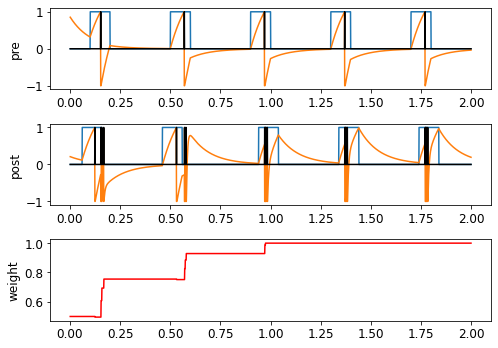

In [68]:
weights = sim.data[layer1_synapses_probe]

import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})

plt.figure(figsize=(7.08,5))

p1 = plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim_pre], label='stim')
plt.plot(sim.trange(), sim.data[p_pre_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_pre]/1000, c='k', label='spikes')
plt.ylabel('pre')
# plt.legend()
# plt.legend(loc='upper right')
# , bbox_to_anchor=(1.8, 1)
p2 = plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[p_stim_post], label='stim')
plt.plot(sim.trange(), sim.data[p_post_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_post]/1000, c='k', label='spikes')
plt.ylabel('post')
# plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sim.trange(), np.array(weights)[:,0,0], label='weight', c = 'red')
plt.ylabel('weight')
# plt.legend()
plt.tight_layout()

# plt.legend(handles=[p1, p2], loc='upper left')

plt.savefig('vdsp_example_3.pdf',dpi=500)
plt.savefig('vdsp_example_3.svg',dpi=500)
plt.savefig('vdsp_example_3.jpeg',dpi=500)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

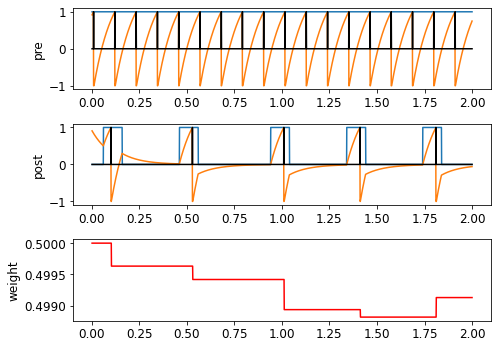

In [11]:
model = nengo.Network()
with model:
    
    pre = nengo.Ensemble(n_neurons=1, dimensions=1,gain=[2],bias=[0],encoders=[[1]],neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))
    post = nengo.Ensemble(n_neurons=1, dimensions=1,gain=[2],bias=[0],encoders=[[1]],
                          neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))
    
    stim_pre = nengo.Node(lambda t: 1)
    stim_post = nengo.Node(lambda t: 1 if ((0.06<t%0.4<0.16) and (t<0.75)) or ((0.14<t%0.4<0.24) and (t>1.25))or((0.14<t%0.4<0.24) and (0.75<t<1.25)) else 0)

    nengo.Connection(stim_pre, pre, synapse=None)
    nengo.Connection(stim_post, post, synapse=None)
    
    #Weight node implementing the VDSP rule
    w = nengo.Node(CustomRule_post_baseline(winit_min=0.5, winit_max=0.5, lr=0.001), size_in=1, size_out=1)
    nengo.Connection(pre.neurons, w, synapse=None)
    nengo.Connection(w, post.neurons, transform=[0],synapse=None) #The synapse does not contribute to the post neuron membrane voltage
    
    
    
    p_stim_pre = nengo.Probe(stim_pre)
    p_stim_post = nengo.Probe(stim_post)
    
    p_pre = nengo.Probe(pre.neurons)
    p_post = nengo.Probe(post.neurons)
    p_pre_v = nengo.Probe(pre.neurons, 'voltage')
    p_post_v = nengo.Probe(post.neurons, 'voltage')
    
    weights = w.output.history
    
with nengo.Simulator(model, optimize=True) as sim:
        
    w.output.set_signal_vmem(sim.signals[sim.model.sig[pre.neurons]["voltage"]])
    w.output.set_signal_out(sim.signals[sim.model.sig[post.neurons]["out"]])    
    
    sim.run(2)
    
    
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})

plt.figure(figsize=(7.08,5))

p1 = plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim_pre], label='stim')
plt.plot(sim.trange(), sim.data[p_pre_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_pre]/1000, c='k', label='spikes')
plt.ylabel('pre')
# plt.legend()
# plt.legend(loc='upper right')
# , bbox_to_anchor=(1.8, 1)
p2 = plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[p_stim_post], label='stim')
plt.plot(sim.trange(), sim.data[p_post_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_post]/1000, c='k', label='spikes')
plt.ylabel('post')
# plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sim.trange(), np.array(weights)[:,0,0], label='weight', c = 'red')
plt.ylabel('weight')
# plt.legend()
plt.tight_layout()

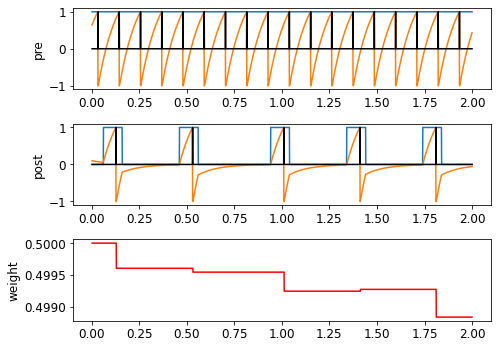

# Step 3 : Now we characterize the VDSP by running the simulation for longer period and plotting the pairs of vmem, dW, and dtau

In [9]:
process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0.1, 1), seed=1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

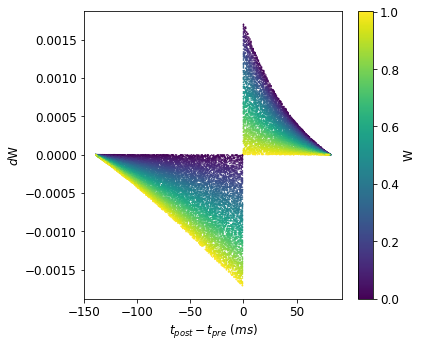

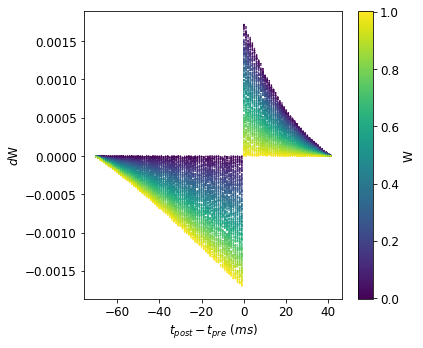

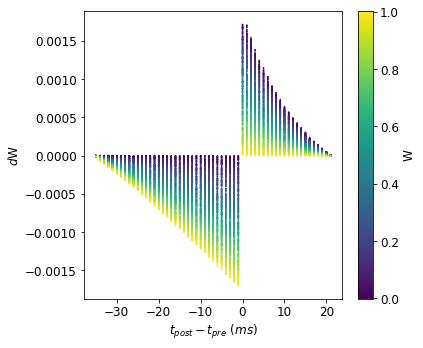

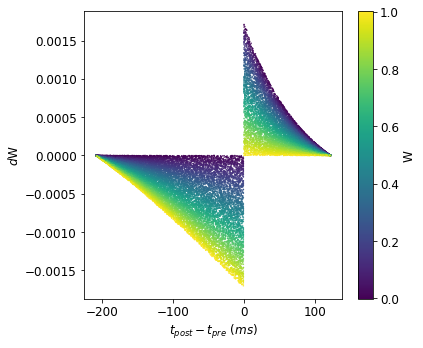

In [17]:
#Simulation time in seconds
sim_time = 2000
tau_rc = 0.2
#Programming voltage
vprog = 0 
lr = 0.001
winit = 0
#Frequency list of post neuron
for freq in [100]:
    #List of leak time constant for post neuron
    for tau_rc in [0.2,0.1,0.05,0.3]:
        #experiment name for saving the plots
        experiment_name = 'freq ' + str(freq)+ ' Hz & tau_rc_post  '+str(tau_rc*1000)+'ms'+str(winit)
        
        model = nengo.Network()
        with model:

            pre = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]],gain=[2], bias=[0], neuron_type=MyLIF_in(tau_rc=tau_rc,min_voltage=-1, tau_ref=0.001))

            post = nengo.Ensemble(n_neurons=1, dimensions=1,noise=process,encoders=[[1]], max_rates=[freq], intercepts=[0],
                                  neuron_type=nengo.LIF(tau_rc=0.03, tau_ref=0.001))

            stim_pre = nengo.Node(lambda t: 1)
            stim_post = nengo.Node(lambda t: 1)

            nengo.Connection(stim_pre, pre, synapse=None)
            nengo.Connection(stim_post, post, synapse=0.005)
    
            w = nengo.Node(CustomRule_post_baseline(winit_min=0, winit_max=0,sample_distance=1,lr=lr,alpha=0), size_in=1, size_out=1 )
            nengo.Connection(pre.neurons, w, synapse=None)
            nengo.Connection(w, post.neurons, transform=[0],synapse=None) #Spikes not transmitted

            p_stim_pre = nengo.Probe(stim_pre)
            p_stim_post = nengo.Probe(stim_post)
            p_pre = nengo.Probe(pre.neurons)
            p_post = nengo.Probe(post.neurons)
            p_pre_v = nengo.Probe(pre.neurons, 'voltage')

            weights = w.output.history
            dw = w.output.update_history
        dt = 0.001
        sim = nengo.Simulator(model,dt = dt)
        w.output.set_signal_vmem(sim.signals[sim.model.sig[pre.neurons]["voltage"]])
        w.output.set_signal_out(sim.signals[sim.model.sig[post.neurons]["out"]])

        sim.run(sim_time)  
        #Now we gather the data from simulation
        pre_data = (sim.data[p_pre]*dt)[:,0]
        post_data = (sim.data[p_post]*dt)[:,0]
        pre_voltage_data = (sim.data[p_pre_v])[:,0]
        t_data = sim.trange()
        w_data = np.array(weights)[:,0,0]

        dw_data = np.array(dw)[:,0,0]
        
        pre_spike_times = t_data[np.where(pre_data == 1)]
        post_spike_times = t_data[np.where(post_data == 1)]

        dw_at_post = dw_data[np.where(post_data == 1)]
#         dw_at_post = np.clip(dw_at_post,-1,1)
        w_at_post = w_data[np.where(post_data == 1)]
        w_at_post = w_at_post - dw_at_post
#         w_at_post = np.clip(w_at_post,0,1.2)

        vmem_at_post = pre_voltage_data[np.where(post_data == 1)]

        tau_pre_nearest = np.ones((len(post_spike_times)))
        for i in range(len(post_spike_times)):
            tau_post = post_spike_times[i]
            neurest_index = (np.abs(pre_spike_times-tau_post)).argmin()
            tau_pre = pre_spike_times[neurest_index]
            tau_pre_nearest[i]=tau_pre
        dtau = post_spike_times - tau_pre_nearest

        #Plot the data
        fig_dir = os.getcwd()
#         fig = plt.figure(figsize=(14,4))

#         ax1 = fig.add_subplot(1,3,1)
#         plt.scatter(dtau[np.nonzero(dw_at_post)]*1000, dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)],s=500/sim_time)
#         cbar = plt.colorbar()
#         cbar.set_label('W')
#         ax1.set_xlabel('tau post-tau pre (ms)')
#         ax1.set_ylabel('dW')
        
#         ax2 = fig.add_subplot(1,3,2)
#         ax2.scatter(vmem_at_post[np.nonzero(dw_at_post)], dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)], s=500/sim_time)
#         cbar = plt.colorbar()
#         cbar.set_label('W')
#         ax2.set_xlabel('Vmem(V)')
#         ax2.set_ylabel('dW')
        
#         ax3 = fig.add_subplot(1,3,3)
#         ax3.scatter(vmem_at_post[np.nonzero(dw_at_post)], dtau[np.nonzero(dw_at_post)]*1000, s=500/sim_time)
#         ax3.set_xlabel('Vmem(V)')
#         ax3.set_ylabel('tau post-tau pre (ms)')
        
#         fig.tight_layout()
#         fig.savefig(fig_dir+ '/vdsp_curve '+experiment_name + '.jpeg',bbox_inches='tight',dpi=500)
#         plt.close()

    #Now we gather the data from simulation
        pre_data = (sim.data[p_pre]*dt)[:,0]
        post_data = (sim.data[p_post]*dt)[:,0]
        pre_voltage_data = (sim.data[p_pre_v])[:,0]
        t_data = sim.trange()
        w_data = np.array(weights)[:,0,0]

        dw_data = np.array(dw)[:,0,0]

        pre_spike_times = t_data[np.where(pre_data == 1)]
        post_spike_times = t_data[np.where(post_data == 1)]

        dw_at_post = dw_data[np.where(post_data == 1)]

        w_at_post = w_data[np.where(post_data == 1)]
        w_at_post = w_at_post - dw_at_post


        vmem_at_post = pre_voltage_data[np.where(post_data == 1)]

        tau_pre_nearest = np.ones((len(post_spike_times)))
        for i in range(len(post_spike_times)):
            tau_post = post_spike_times[i]
            neurest_index = (np.abs(pre_spike_times-tau_post)).argmin()
            tau_pre = pre_spike_times[neurest_index]
            tau_pre_nearest[i]=tau_pre
        dtau = post_spike_times - tau_pre_nearest

        #Get ISI for pre-neuron
        isi = pre_spike_times[2]-pre_spike_times[1]


        for i in range(len(dw_at_post)):
            if (dtau[i]>0) and (dw_at_post[i]<0) :
                dtau[i] -= isi 


        #Plot the data
        fig_dir = os.getcwd()
        import matplotlib as mpl
        mpl.rcParams.update({'font.size': 12})

        fig = plt.figure(figsize=(6,5))

        ax1 = fig.add_subplot()
        plt.scatter(dtau[np.nonzero(dw_at_post)]*1000, dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)],s=500/sim_time)
        cbar = plt.colorbar()
        cbar.set_label('W')
        ax1.set_xlabel('$ t_{post}-t_{pre}~(ms) $')
        ax1.set_ylabel('$d$W')
        fig.tight_layout()
        fig.savefig(fig_dir+ '/vdsp_curve '+experiment_name + '.png',bbox_inches='tight',dpi=800)

In [ ]:
#Simulation time in seconds
sim_time = 2000
tau_rc = 0.2
#Programming voltage
vprog = 0 
lr = 0.001
winit = 0
#Frequency list of post neuron
for freq in [100]:
    #List of leak time constant for post neuron
    for tau_rc in [0.2,0.1,0.05,0.3]:
        #experiment name for saving the plots
        experiment_name = 'freq ' + str(freq)+ ' Hz & tau_rc_post  '+str(tau_rc*1000)+'ms'+str(winit)
        
        model = nengo.Network()
        with model:

            pre = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]],gain=[2], bias=[0], neuron_type=MyLIF_in(tau_rc=tau_rc,min_voltage=-1, tau_ref=0.001))

            post = nengo.Ensemble(n_neurons=1, dimensions=1,noise=process,encoders=[[1]], max_rates=[freq], intercepts=[0],
                                  neuron_type=nengo.LIF(tau_rc=0.03, tau_ref=0.001))

            stim_pre = nengo.Node(lambda t: 1)
            stim_post = nengo.Node(lambda t: 1)

            nengo.Connection(stim_pre, pre, synapse=None)
            nengo.Connection(stim_post, post, synapse=0.005)
    
            w = nengo.Node(CustomRule_post_baseline(winit_min=0, winit_max=0,sample_distance=1,lr=lr,alpha=0), size_in=1, size_out=1 )
            nengo.Connection(pre.neurons, w, synapse=None)
            nengo.Connection(w, post.neurons, transform=[0],synapse=None) #Spikes not transmitted

            p_stim_pre = nengo.Probe(stim_pre)
            p_stim_post = nengo.Probe(stim_post)
            p_pre = nengo.Probe(pre.neurons)
            p_post = nengo.Probe(post.neurons)
            p_pre_v = nengo.Probe(pre.neurons, 'voltage')

            weights = w.output.history
            dw = w.output.update_history
        dt = 0.001
        sim = nengo.Simulator(model,dt = dt)
        w.output.set_signal_vmem(sim.signals[sim.model.sig[pre.neurons]["voltage"]])
        w.output.set_signal_out(sim.signals[sim.model.sig[post.neurons]["out"]])

        sim.run(sim_time)  
        #Now we gather the data from simulation
        pre_data = (sim.data[p_pre]*dt)[:,0]
        post_data = (sim.data[p_post]*dt)[:,0]
        pre_voltage_data = (sim.data[p_pre_v])[:,0]
        t_data = sim.trange()
        w_data = np.array(weights)[:,0,0]

        dw_data = np.array(dw)[:,0,0]
        
        pre_spike_times = t_data[np.where(pre_data == 1)]
        post_spike_times = t_data[np.where(post_data == 1)]

        dw_at_post = dw_data[np.where(post_data == 1)]
#         dw_at_post = np.clip(dw_at_post,-1,1)
        w_at_post = w_data[np.where(post_data == 1)]
        w_at_post = w_at_post - dw_at_post
#         w_at_post = np.clip(w_at_post,0,1.2)

        vmem_at_post = pre_voltage_data[np.where(post_data == 1)]

        tau_pre_nearest = np.ones((len(post_spike_times)))
        for i in range(len(post_spike_times)):
            tau_post = post_spike_times[i]
            neurest_index = (np.abs(pre_spike_times-tau_post)).argmin()
            tau_pre = pre_spike_times[neurest_index]
            tau_pre_nearest[i]=tau_pre
        dtau = post_spike_times - tau_pre_nearest

        #Plot the data
        fig_dir = os.getcwd()
#         fig = plt.figure(figsize=(14,4))

#         ax1 = fig.add_subplot(1,3,1)
#         plt.scatter(dtau[np.nonzero(dw_at_post)]*1000, dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)],s=500/sim_time)
#         cbar = plt.colorbar()
#         cbar.set_label('W')
#         ax1.set_xlabel('tau post-tau pre (ms)')
#         ax1.set_ylabel('dW')
        
#         ax2 = fig.add_subplot(1,3,2)
#         ax2.scatter(vmem_at_post[np.nonzero(dw_at_post)], dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)], s=500/sim_time)
#         cbar = plt.colorbar()
#         cbar.set_label('W')
#         ax2.set_xlabel('Vmem(V)')
#         ax2.set_ylabel('dW')
        
#         ax3 = fig.add_subplot(1,3,3)
#         ax3.scatter(vmem_at_post[np.nonzero(dw_at_post)], dtau[np.nonzero(dw_at_post)]*1000, s=500/sim_time)
#         ax3.set_xlabel('Vmem(V)')
#         ax3.set_ylabel('tau post-tau pre (ms)')
        
#         fig.tight_layout()
#         fig.savefig(fig_dir+ '/vdsp_curve '+experiment_name + '.jpeg',bbox_inches='tight',dpi=500)
#         plt.close()

    #Now we gather the data from simulation
        pre_data = (sim.data[p_pre]*dt)[:,0]
        post_data = (sim.data[p_post]*dt)[:,0]
        pre_voltage_data = (sim.data[p_pre_v])[:,0]
        t_data = sim.trange()
        w_data = np.array(weights)[:,0,0]

        dw_data = np.array(dw)[:,0,0]

        pre_spike_times = t_data[np.where(pre_data == 1)]
        post_spike_times = t_data[np.where(post_data == 1)]

        dw_at_post = dw_data[np.where(post_data == 1)]

        w_at_post = w_data[np.where(post_data == 1)]
        w_at_post = w_at_post - dw_at_post


        vmem_at_post = pre_voltage_data[np.where(post_data == 1)]

        tau_pre_nearest = np.ones((len(post_spike_times)))
        for i in range(len(post_spike_times)):
            tau_post = post_spike_times[i]
            neurest_index = (np.abs(pre_spike_times-tau_post)).argmin()
            tau_pre = pre_spike_times[neurest_index]
            tau_pre_nearest[i]=tau_pre
        dtau = post_spike_times - tau_pre_nearest

        #Get ISI for pre-neuron
        isi = pre_spike_times[2]-pre_spike_times[1]


        for i in range(len(dw_at_post)):
            if (dtau[i]>0) and (dw_at_post[i]<0) :
                dtau[i] -= isi 


        #Plot the data
        fig_dir = os.getcwd()
        import matplotlib as mpl
        mpl.rcParams.update({'font.size': 12})

        fig = plt.figure(figsize=(6,5))

        ax1 = fig.add_subplot()
        plt.scatter(dtau[np.nonzero(dw_at_post)]*1000, dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)],s=500/sim_time)
        cbar = plt.colorbar()
        cbar.set_label('W')
        ax1.set_xlabel('$ t_{post}-t_{pre}~(ms) $')
        ax1.set_ylabel('$d$W')
        fig.tight_layout()
        fig.savefig(fig_dir+ '/vdsp_curve '+experiment_name + '.png',bbox_inches='tight',dpi=800)

In [24]:
# #Now we gather the data from simulation
# pre_data = (sim.data[p_pre]*dt)[:,0]
# post_data = (sim.data[p_post]*dt)[:,0]
# pre_voltage_data = (sim.data[p_pre_v])[:,0]
# t_data = sim.trange()
# w_data = np.array(weights)[:,0,0]

# dw_data = np.array(dw)[:,0,0]

# pre_spike_times = t_data[np.where(pre_data == 1)]
# post_spike_times = t_data[np.where(post_data == 1)]

# dw_at_post = dw_data[np.where(post_data == 1)]

# w_at_post = w_data[np.where(post_data == 1)]
# w_at_post = w_at_post - dw_at_post


# vmem_at_post = pre_voltage_data[np.where(post_data == 1)]

# tau_pre_nearest = np.ones((len(post_spike_times)))
# for i in range(len(post_spike_times)):
#     tau_post = post_spike_times[i]
#     neurest_index = (np.abs(pre_spike_times-tau_post)).argmin()
#     tau_pre = pre_spike_times[neurest_index]
#     tau_pre_nearest[i]=tau_pre
# dtau = post_spike_times - tau_pre_nearest

# #Get ISI for pre-neuron
# isi = pre_spike_times[2]-pre_spike_times[1]


# for i in range(len(dw_at_post)):
#     if (dtau[i]>0) and (dw_at_post[i]<0) :
#         dtau[i] -= isi 
    

# #Plot the data
# fig_dir = os.getcwd()
# fig = plt.figure(figsize=(14,4))

# ax1 = fig.add_subplot(1,3,1)
# plt.scatter(dtau[np.nonzero(dw_at_post)]*1000, dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)],s=500/sim_time)
# cbar = plt.colorbar()
# cbar.set_label('W')
# ax1.set_xlabel('tau post-tau pre (ms)')
# ax1.set_ylabel('dW')

# ax2 = fig.add_subplot(1,3,2)
# ax2.scatter(vmem_at_post[np.nonzero(dw_at_post)], dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)], s=500/sim_time)
# cbar = plt.colorbar()
# cbar.set_label('W')
# ax2.set_xlabel('Vmem(V)')
# ax2.set_ylabel('dW')

# ax3 = fig.add_subplot(1,3,3)
# ax3.scatter(vmem_at_post[np.nonzero(dw_at_post)], dtau[np.nonzero(dw_at_post)]*1000, s=500/sim_time)
# ax3.set_xlabel('Vmem(V)')
# ax3.set_ylabel('tau post-tau pre (ms)')

# fig.tight_layout()
# fig.savefig(fig_dir+ '/vdsp_curve '+experiment_name + '.jpeg',bbox_inches='tight',dpi=500)

In [25]:
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 12})

# fig = plt.figure(figsize=(6,5))

# ax1 = fig.add_subplot()
# plt.scatter(dtau[np.nonzero(dw_at_post)]*1000, dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)],s=500/sim_time)
# cbar = plt.colorbar()
# cbar.set_label('W')
# ax1.set_xlabel('$ t_{post}-t_{pre}~(ms) $')
# ax1.set_ylabel('$d$W')
# fig.tight_layout()
# fig.savefig('vdsp_curve_nengo.png',bbox_inches='tight',dpi=500)
# fig.savefig('vdsp_curve_nengo.svg',bbox_inches='tight',dpi=500)
# fig.savefig('vdsp_curve_nengo.pdf',bbox_inches='tight',dpi=500)

# Triplet of spikes

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

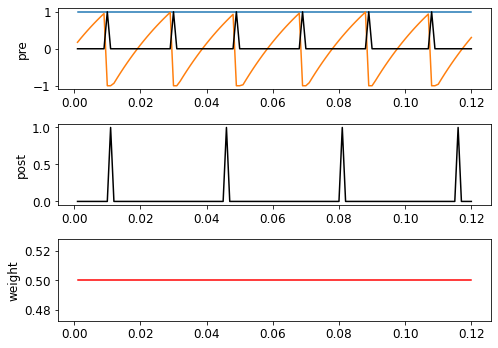

In [114]:
process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.01), seed=1)
model = nengo.Network()
with model:
    
    pre = nengo.Ensemble(n_neurons=1, dimensions=1,gain=[3.5],bias=[0],encoders=[[1]],neuron_type=MyLIF_in(tau_rc=0.03, min_voltage=-1))
    post = nengo.Ensemble(n_neurons=1, noise=process,dimensions=1,intercepts=[0],max_rates=[50],encoders=[[1]],
                          neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))
    
    stim_pre = nengo.Node(lambda t: 1)
#     stim_post = nengo.Node(lambda t: 1 if ((0.06<t%0.4<0.16) and (t<0.75)) or ((0.14<t%0.4<0.24) and (t>1.25))or((0.14<t%0.4<0.24) and (0.75<t<1.25)) else 0)
    stim_post = nengo.Node(lambda t: 1)
    
    nengo.Connection(stim_pre, pre, synapse=None)
    nengo.Connection(stim_post, post, synapse=None)
    
    #Weight node implementing the VDSP rule
    w = nengo.Node(CustomRule_post_baseline(winit_min=0.5, winit_max=0.5, lr=0.001), size_in=1, size_out=1)
    nengo.Connection(pre.neurons, w, synapse=None)
    nengo.Connection(w, post.neurons, transform=[0],synapse=None) #The synapse does not contribute to the post neuron membrane voltage
    
    p_stim_pre = nengo.Probe(stim_pre)
    p_stim_post = nengo.Probe(stim_post)
    
    p_pre = nengo.Probe(pre.neurons)
    p_post = nengo.Probe(post.neurons)
    p_pre_v = nengo.Probe(pre.neurons, 'voltage')
    p_post_v = nengo.Probe(post.neurons, 'voltage')
    weights = w.output.history
#     weights = w.output.history
    dw = w.output.update_history
    
with nengo.Simulator(model, optimize=True) as sim:
        
    w.output.set_signal_vmem(sim.signals[sim.model.sig[pre.neurons]["voltage"]])
    w.output.set_signal_out(sim.signals[sim.model.sig[post.neurons]["out"]])    
    
    sim.run(0.12)
    
    
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})

plt.figure(figsize=(7.08,5))

p1 = plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim_pre], label='stim')
plt.plot(sim.trange(), sim.data[p_pre_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_pre]/1000, c='k', label='spikes')
plt.ylabel('pre')
# plt.legend()
# plt.legend(loc='upper right')
# , bbox_to_anchor=(1.8, 1)
p2 = plt.subplot(3, 1, 2)
# plt.plot(sim.trange(), sim.data[p_stim_post], label='stim')
# plt.plot(sim.trange(), sim.data[p_post_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_post]/1000, c='k', label='spikes')
plt.ylabel('post')
# plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sim.trange(), np.array(weights)[:,0,0], label='weight', c = 'red')
plt.ylabel('weight')
# plt.legend()
plt.tight_layout()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

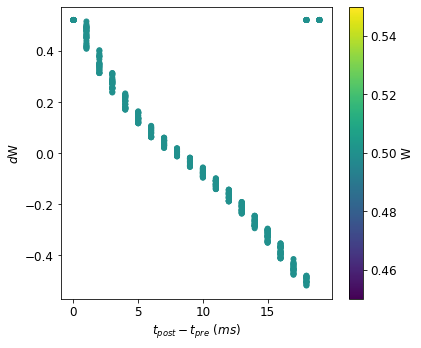

In [117]:
dt = 0.001
sim_time = 20
process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.01), seed=1)
model = nengo.Network()
with model:
    
    pre = nengo.Ensemble(n_neurons=1, dimensions=1,gain=[3.5],bias=[0],encoders=[[1]],neuron_type=MyLIF_in(tau_rc=0.03, min_voltage=-1))
    post = nengo.Ensemble(n_neurons=1, noise=process,dimensions=1,intercepts=[0],max_rates=[50],encoders=[[1]],
                          neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))
    
    stim_pre = nengo.Node(lambda t: 1)
#     stim_post = nengo.Node(lambda t: 1 if ((0.06<t%0.4<0.16) and (t<0.75)) or ((0.14<t%0.4<0.24) and (t>1.25))or((0.14<t%0.4<0.24) and (0.75<t<1.25)) else 0)
    stim_post = nengo.Node(lambda t: 1)
    
    nengo.Connection(stim_pre, pre, synapse=None)
    nengo.Connection(stim_post, post, synapse=None)
    
    #Weight node implementing the VDSP rule
    w = nengo.Node(CustomRule_post_baseline(winit_min=0.5, winit_max=0.5, lr=1), size_in=1, size_out=1)
    nengo.Connection(pre.neurons, w, synapse=None)
    nengo.Connection(w, post.neurons, transform=[0],synapse=None) #The synapse does not contribute to the post neuron membrane voltage
    
    p_stim_pre = nengo.Probe(stim_pre)
    p_stim_post = nengo.Probe(stim_post)
    
    p_pre = nengo.Probe(pre.neurons)
    p_post = nengo.Probe(post.neurons)
    p_pre_v = nengo.Probe(pre.neurons, 'voltage')
    p_post_v = nengo.Probe(post.neurons, 'voltage')
    weights = w.output.history
#     weights = w.output.history
    dw = w.output.update_history
    
with nengo.Simulator(model, optimize=True,dt=dt) as sim:
        
    w.output.set_signal_vmem(sim.signals[sim.model.sig[pre.neurons]["voltage"]])
    w.output.set_signal_out(sim.signals[sim.model.sig[post.neurons]["out"]])    
    
    sim.run(sim_time)



pre_data = (sim.data[p_pre]*dt)[:,0]
post_data = (sim.data[p_post]*dt)[:,0]
pre_voltage_data = (sim.data[p_pre_v])[:,0]
t_data = sim.trange()
w_data = np.array(weights)[:,0,0]

dw_data = np.array(dw)[:,0,0]

pre_spike_times = t_data[np.where(pre_data == 1)]
post_spike_times = t_data[np.where(post_data == 1)]

dw_at_post = dw_data[tuple(np.array(np.where(post_data == 1))+1)]
#         dw_at_post = np.clip(dw_at_post,-1,1)
w_at_post = w_data[tuple(np.array(np.where(post_data == 1))+1)]
# w_at_post = w_at_post - dw_at_post
#         w_at_post = np.clip(w_at_post,0,1.2)

vmem_at_post = pre_voltage_data[np.where(post_data == 1)]

tau_pre_nearest = np.ones((len(post_spike_times)))
for i in range(len(post_spike_times)):
    tau_post = post_spike_times[i]
    neurest_index = (np.abs(pre_spike_times-tau_post)).argmin()
    temp = pre_spike_times[neurest_index]
    if (temp>tau_post):
        tau_pre = pre_spike_times[neurest_index-1]
    else:
        tau_pre = pre_spike_times[neurest_index]
    tau_pre_nearest[i]=tau_pre
dtau = post_spike_times - tau_pre_nearest


import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(6,5))

ax1 = fig.add_subplot()
plt.scatter(dtau[np.nonzero(dw_at_post)]*1000, dw_at_post[np.nonzero(dw_at_post)],c=w_at_post[np.nonzero(dw_at_post)],s=500/sim_time)
cbar = plt.colorbar()
cbar.set_label('W')
ax1.set_xlabel('$ t_{post}-t_{pre}~(ms) $')
ax1.set_ylabel('$d$W')
fig.tight_layout()
fig.savefig('vdsp_curve_pre_post_pre.png',bbox_inches='tight',dpi=500)
fig.savefig('vdsp_curve_pre_post_pre.svg',bbox_inches='tight',dpi=500)
fig.savefig('vdsp_curve_pre_post_pre.pdf',bbox_inches='tight',dpi=500)

In [118]:
w_at_post

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

In [105]:
np.where(post_data == 1)

(array([ 14,  49,  84, 119, 154, 189]),)

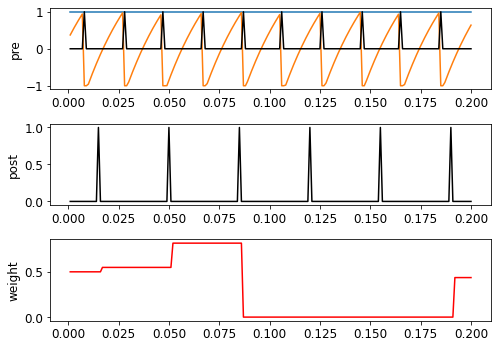

In [99]:
plt.figure(figsize=(7.08,5))

p1 = plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim_pre], label='stim')
plt.plot(sim.trange(), sim.data[p_pre_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_pre]/1000, c='k', label='spikes')
plt.ylabel('pre')
# plt.legend()
# plt.legend(loc='upper right')
# , bbox_to_anchor=(1.8, 1)
p2 = plt.subplot(3, 1, 2)
# plt.plot(sim.trange(), sim.data[p_stim_post], label='stim')
# plt.plot(sim.trange(), sim.data[p_post_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_post]/1000, c='k', label='spikes')
plt.ylabel('post')
# plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sim.trange(), np.array(weights)[:,0,0], label='weight', c = 'red')
plt.ylabel('weight')
# plt.legend()
plt.tight_layout()

In [37]:
dtau[np.nonzero(dw_at_post)]

array([], dtype=float64)

In [38]:
dw_at_post

array([ 0.,  0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,
       -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
        0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0., -0., -0., -0.,
        0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,
       -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
       -0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0., -0., -0., -0.,
        0.,  0., -0., -0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,
       -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
        0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
        0.,  0., -0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,
       -0.,  0.,  0., -0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
       -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,
        0., -0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -0.,
       -0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,  0

# Step 4 : Now we perform the pavlov's dog experiment 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

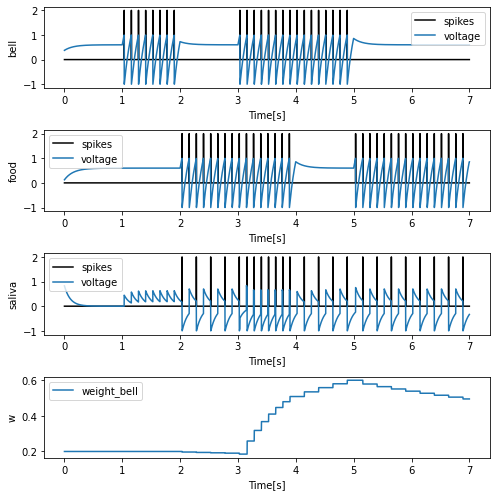

In [41]:
wmax = 1/5
winit = 1/5
lr = 1
model = nengo.Network()
with model:

    bell = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0.6], neuron_type=MyLIF_in(tau_rc=0.15, min_voltage=-1))
    food = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0.6], neuron_type=MyLIF_in(tau_rc=0.15, min_voltage=-1))
    saliva = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0],neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))

    stim_food = nengo.Node(lambda t: 1 if (2<t%10<4 or 5<t%10<7) else 0)
    stim_bell = nengo.Node(lambda t: 1 if (3<t%10<5 or 1<t%10<2) else 0)

    nengo.Connection(stim_food, food, synapse=None)
    nengo.Connection(stim_bell, bell, synapse=None)

    w = nengo.Node(CustomRule_post_tio2(winit_min=winit,winit_max=winit), size_in=1, size_out=1)  
    nengo.Connection(bell.neurons, w, synapse=None)
    nengo.Connection(w, saliva.neurons,transform=[wmax*500], synapse=None)

    nengo.Connection(food.neurons, saliva.neurons,transform=[wmax*0.25], synapse=None)

    p_bell = nengo.Probe(bell.neurons)
    p_food = nengo.Probe(food.neurons)    
    p_saliva = nengo.Probe(saliva.neurons)
    p_saliva_v = nengo.Probe(saliva.neurons, 'voltage')
    p_food_v = nengo.Probe(food.neurons, 'voltage')
    p_bell_v = nengo.Probe(bell.neurons, 'voltage')

    weights = w.output.history

sim = nengo.Simulator(model)

# w.output.set_signal(sim.signals[sim.model.sig[saliva.neurons]["voltage"]])
w.output.set_signal_vmem(sim.signals[sim.model.sig[bell.neurons]["voltage"]])
w.output.set_signal_out(sim.signals[sim.model.sig[saliva.neurons]["out"]])

sim.run(7)  

plt.figure(figsize=(7,7))

plt.subplot(4, 1, 1)
# plt.title('a')

plt.plot(sim.trange(), sim.data[p_bell]/500, c='k', label='spikes')
plt.plot(sim.trange(), sim.data[p_bell_v], label='voltage')
plt.ylabel('bell')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 2)
# plt.title('b')
plt.plot(sim.trange(), sim.data[p_food]/500, c='k', label='spikes')
plt.plot(sim.trange(), sim.data[p_food_v], label='voltage')
plt.ylabel('food')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 3)
# plt.title('c')
plt.plot(sim.trange(), sim.data[p_saliva]/500, c='k', label='spikes')
plt.plot(sim.trange(), sim.data[p_saliva_v], label='voltage')
plt.ylabel('saliva')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 4)
# plt.title('d')
plt.plot(sim.trange(), np.array(weights)[:,:,0], label='weight_bell')
plt.xlabel("Time[s]")
plt.ylabel("w")
plt.legend()

plt.tight_layout()
plt.savefig('dog'+'winit'+str(winit)+'wmax'+str(wmax)+'lr'+str(lr)+'.jpeg', dpi=400)
# plt.close()

## Adding noise to input

In [44]:
process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.09), seed=1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

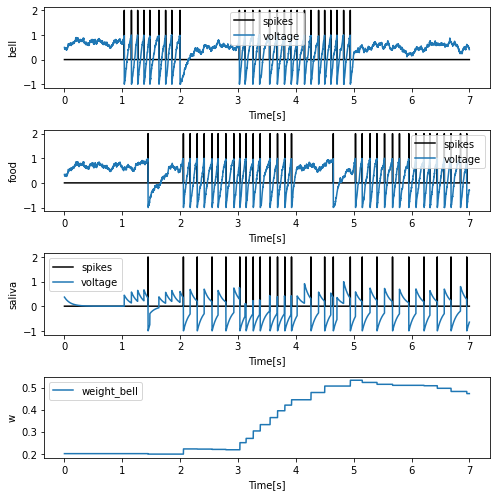

In [40]:
wmax = 1/5
winit = 1/5
lr = 1
model = nengo.Network()
with model:

    bell = nengo.Ensemble(n_neurons=1, noise=process, dimensions=1, encoders=[[1]], gain=[2], bias=[0.6], neuron_type=(MyLIF_in(tau_rc=0.15, min_voltage=-1)))
    food = nengo.Ensemble(n_neurons=1, noise=process, dimensions=1, encoders=[[1]], gain=[2], bias=[0.6], neuron_type=MyLIF_in(tau_rc=0.15, min_voltage=-1))
    saliva = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0],neuron_type=MyLIF_in(tau_rc=0.1, min_voltage=-1))

    stim_food = nengo.Node(lambda t: 1 if (2<t%10<4 or 5<t%10<7) else 0)
    stim_bell = nengo.Node(lambda t: 1 if (3<t%10<5 or 1<t%10<2) else 0)

    nengo.Connection(stim_food, food, synapse=None)
    nengo.Connection(stim_bell, bell, synapse=None)

    w = nengo.Node(CustomRule_post_tio2(winit_min=winit,winit_max=winit), size_in=1, size_out=1)  
    nengo.Connection(bell.neurons, w, synapse=None)
    nengo.Connection(w, saliva.neurons,transform=[wmax*500], synapse=None)

    nengo.Connection(food.neurons, saliva.neurons,transform=[wmax*0.25], synapse=None)

    p_bell = nengo.Probe(bell.neurons)
    p_food = nengo.Probe(food.neurons)    
    p_saliva = nengo.Probe(saliva.neurons)
    p_saliva_v = nengo.Probe(saliva.neurons, 'voltage')
    p_food_v = nengo.Probe(food.neurons, 'voltage')
    p_bell_v = nengo.Probe(bell.neurons, 'voltage')

    weights = w.output.history

sim = nengo.Simulator(model)

# w.output.set_signal(sim.signals[sim.model.sig[saliva.neurons]["voltage"]])
w.output.set_signal_vmem(sim.signals[sim.model.sig[bell.neurons]["voltage"]])
w.output.set_signal_out(sim.signals[sim.model.sig[saliva.neurons]["out"]])

sim.run(7)  

plt.figure(figsize=(7,7))

plt.subplot(4, 1, 1)
# plt.title('a')

plt.plot(sim.trange(), sim.data[p_bell]/500, c='k', label='spikes')
plt.plot(sim.trange(), sim.data[p_bell_v], label='voltage')
plt.ylabel('bell')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 2)
# plt.title('b')
plt.plot(sim.trange(), sim.data[p_food]/500, c='k', label='spikes')
plt.plot(sim.trange(), sim.data[p_food_v], label='voltage')
plt.ylabel('food')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 3)
# plt.title('c')
plt.plot(sim.trange(), sim.data[p_saliva]/500, c='k', label='spikes')
plt.plot(sim.trange(), sim.data[p_saliva_v], label='voltage')
plt.ylabel('saliva')
plt.xlabel("Time[s]")
plt.legend()

plt.subplot(4, 1, 4)
# plt.title('d')
plt.plot(sim.trange(), np.array(weights)[:,:,0], label='weight_bell')
plt.xlabel("Time[s]")
plt.ylabel("w")
plt.legend()

plt.tight_layout()
plt.savefig('dog'+'winit'+str(winit)+'wmax'+str(wmax)+'lr'+str(lr)+'noisy'+'.jpeg', dpi=400)
# plt.close()

In [31]:
import keras

In [43]:
(image_train, label_train), (image_test, label_test) = (keras.datasets.mnist.load_data())

In [46]:
image_train.mean()

33.318421449829934

In [46]:
model = nengo.Network()
with model:
    #pre synaptic neuron. Single neuron, with LIF neuron and reset voltage of -1 V. 
    pre = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0],
                        neuron_type=MyLIF_in(tau_rc=0.2, min_voltage=-1, tau_ref=0.002))

#     pre = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], max_rates=[20], intercepts=[0],
#                         neuron_type=MyLIF_in(tau_rc=0.06, min_voltage=-1, tau_ref=0.002))


    #post synaptic neuron.
    post = nengo.Ensemble(n_neurons=1, dimensions=1,noise=process,encoders=[[1]], max_rates=[20], intercepts=[0],
                                  neuron_type=nengo.LIF(tau_rc=0.03, tau_ref=0.001))
    
    #Stimuli for pre neuron
    stim_pre = nengo.Node(lambda t: 1 )#if 0.1<t%0.5<0.3 else 0)
    #Stimuli for post neuron
    stim_post = nengo.Node(lambda t: 1)# if 0.25<t%0.4<0.35 else 0)
    #Connect the stimuli to respective neurons
    nengo.Connection(stim_pre, pre, synapse=None)
    nengo.Connection(stim_post, post, synapse=None)
    
    
    w = nengo.Node(CustomRule_post_baseline(winit_min=0.5, winit_max=0.5, lr=0.001), size_in=1, size_out=1)
    nengo.Connection(pre.neurons, w, synapse=None)
    nengo.Connection(w, post.neurons, transform=[0],synapse=None) #The synapse does not contribute to the post neuron membrane voltage
    
    
    #Probe definition
    p_stim_pre = nengo.Probe(stim_pre)
    p_stim_post = nengo.Probe(stim_post)
    p_pre = nengo.Probe(pre.neurons)
    p_post = nengo.Probe(post.neurons)
    p_post_v = nengo.Probe(post.neurons, 'voltage')
    p_pre_v = nengo.Probe(pre.neurons, 'voltage')
    
    weights = w.output.history
    
with nengo.Simulator(model, optimize=True) as sim:
        
    w.output.set_signal_vmem(sim.signals[sim.model.sig[pre.neurons]["voltage"]])
    w.output.set_signal_out(sim.signals[sim.model.sig[post.neurons]["out"]])    
    
    sim.run(0.5)
    
# #Run the simulation for 2 seconds    
# sim = nengo.Simulator(model, dt=0.001)
# sim.run(0.5)

#Plot the simulated data
# plt.figure(figsize=(12,5))
# plt.subplot(2, 1, 1)
# plt.plot(sim.trange(), sim.data[p_stim_pre], label='stim')
# plt.plot(sim.trange(), sim.data[p_pre_v], label='voltage')
# plt.plot(sim.trange(), sim.data[p_pre]/1000, c='k', label='spikes')
# plt.ylabel('pre')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(sim.trange(), sim.data[p_stim_post], label='stim')
# # plt.plot(sim.trange(), sim.data[p_post_v], label='voltage')
# plt.plot(sim.trange(), sim.data[p_post]/1000, c='k', label='spikes')
# plt.ylabel('post')
# plt.legend()
# plt.savefig('VDSP_character_neuron',bbox_inches='tight',dpi=500)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

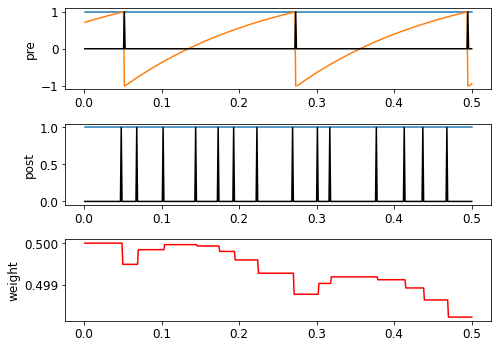

In [49]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})

plt.figure(figsize=(7.08,5))

plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim_pre], label='stim')
plt.plot(sim.trange(), sim.data[p_pre_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_pre]/1000, c='k', label='spikes')
plt.ylabel('pre')
# plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[p_stim_post], label='stim')
# plt.plot(sim.trange(), sim.data[p_post_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_post]/1000, c='k', label='spikes')
plt.ylabel('post')
# plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sim.trange(), np.array(weights)[:,0,0], label='weight',c='red')
plt.ylabel('weight')
# plt.legend()
plt.tight_layout()
plt.savefig('vdsp_example_neuron.pdf')
plt.savefig('vdsp_example_neuron.svg')
plt.savefig('vdsp_example_neuron.jpeg')